In [1]:
import dut_func as dut
import serial
import time
import struct
import numpy as np
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

In [86]:
ser = serial.Serial('COM7', 9600, timeout=1)
dut.connect(ser)

In [209]:
dut.disconnect()

In [87]:
dut.power_on()
dut.reset_chip()
dut.reset_dpe()

Setting vrefs to default


In [88]:
dut.power_on()

Setting vrefs to default


In [89]:
drv.clk_stop('ADC_CK')
drv.clk_stop('CK_ARRAY')
drv.clk_config('ADC_CK', divisor=20)
drv.clk_config('CK_ARRAY', divisor=20)
drv.clk_start('ADC_CK')
drv.clk_start('CK_ARRAY')

Setting ADC_CK freq=5000.0kHz
Setting CK_ARRAY freq=5000.0kHz


In [57]:
drv.gpio_pin_set('H', 1)

In [16]:
ar=2
r=31
c=0


Vreads = np.arange(0, 0.5, 0.01)
# Vgates = np.arange(0,5,0.5)
# Vgates = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 5]
# Vgates = [4, 3, 2, 1.5]
Vgates = [5]
Vref = 0.5

volts_set = []

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_single(vread, Vgate, array=ar, row=r, col=c, gain=2) )

5.00-

In [194]:
a0.read_single(0.2, 5.0, array=2, row=0, col=0, gain=4)

6.842619745845547e-09

In [178]:
a0.read_single_int(0.2, 5.0, array=2, row=0, col=0, gain=3)

3.421309872922773e-08

In [201]:
a0.read_single_int(0.2, 5.0, array=0, row=0, col=0, gain=-1)

6.842619745845546e-06

In [208]:
dut.py_logic_analyzer()

1 	PWR_GOOD
1 	NRESET_FULL_CHIP
1 	NRESET_DPE_ENGINE
0 	ARRAY_EN<0>
0 	ARRAY_EN<1>
0 	ARRAY_EN<2>
1 	NFORCE_SAFE0
0 	NFORCE_SAFE1
0 	NFORCE_SAFE2
0 	ADC_SEL_EXT
0 	DPE_EXT_OVERRIDE_EN
0 	DPE_EXT_SH
1 	ADC_DONE
0 	ADC_FIFO_ADVANCE
0 	ADC_FIFO_EN<0>
0 	ADC_FIFO_EN<1>
1 	ADC_FIFO_EN<2>
0 	ADC_FIFO_EN<3>


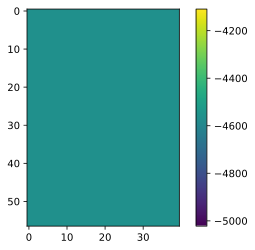

5.00-

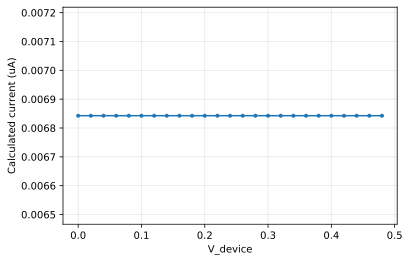

In [180]:
ar=0
r=1
c=1
gg = 4
Vreads = np.arange(0, 0.5, 0.02)
Vgates = [5]
Vref = 0.5

volts_set = []

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_single_int(vread, Vgate, array=ar, row=r, col=c, gain=gg, Vref = Vref) )
    volts_set.append(volts)
    
for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('V_device')
plt.ylabel('Calculated current (uA)')
plt.grid(True, alpha=0.3)

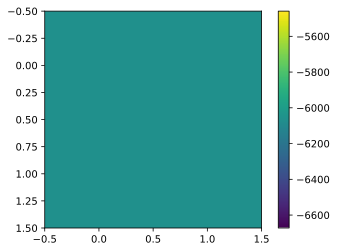

In [181]:
arr = 1
numRows = 2
numCols = 2

GHistory = []
VHistory = []

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.3, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])

_gain_ratio = [
    1e3,
    5e3,
    30e3,
    200e3,
    1e6
]

vRead = 0.2
Vgate = 5
Vref = 0.5

vOffset = -0.08
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)

Gmap0post = np.zeros((numRows, numCols))
for rr in range(numRows):
        for cc in range(numCols):
            adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
            VADC_read_first = dut.adc2volt(adc_raw)
            gainFirst = adc_raw >> 10
            secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
            secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
            dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
            VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
            finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
            dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
            rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
        
            Gmap0post[rr,cc] = 1e6*rdCurr/vRead
plt.imshow(Gmap0post)
plt.colorbar()

In [21]:
volt_in = np.arange(0.5, 4.0, 0.01)
volt_out_list = []
adc_raw=[]
for addr_fifo in range(2):
    print(addr_fifo, end='->')
    data = dut.calibrate_adc(volt_in, addr_fifo=addr_fifo )
    volt_out_list.append( [dut.adc2volt(d) for d in data] )
    adc_raw.append(data)

0->1->

In [ ]:
plt.grid(True, alpha=0.3)
for volt_out in volt_out_list:
#     plt.plot(volt_in, [v+3.3-0.5 for v in volt_out], linewidth=1)
    plt.plot(volt_in, volt_out, linewidth=1)
plt.ylim(0.4,4.1)
plt.xlim(0.4,4.1)


In [205]:
_gain_ratio = [
    1e3,
    5e3,
    30e3,
    200e3,
    1e6
]
adc_raw=a0.read_single_int(0.2, 5.0, array=0, row=1, col=1, gain=3, raw=True)
ADCVolt = dut.adc2volt(adc_raw)
print(ADCVolt)
gain_read = adc_raw >> 10
print(gain_read)
print((ADCVolt-0.5)/_gain_ratio[gain_read])

0.5068426197458455
3
3.421309872922773e-08


In [133]:
Vreads = np.arange(0, 0.4, 0.02)
Vgate = 5
Vref = 0.5
arr = 0
rr = 2
cc = 2

volts = []
for vread in Vreads:
    #volts.append( a0.pic_read_single(ar, r, c, Vread = vread, skip_conf=False, gain=gg) )
    volts.append( a0.read_single_int(vread, Vgate, array=arr, row=rr, col=cc, gain=-1)
plt.plot(Vreads, [i*1e6 for i in volts], '.-')
    
plt.xlabel('V_device')
plt.ylabel('Calculated current (uA)')
plt.grid(True, alpha=0.3)

SyntaxError: invalid syntax (<ipython-input-133-1091f7256e18>, line 12)

In [131]:
print(volts)

[6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09, 6.842619745845547e-09]


Working on array 0 , device (row= 0 col= 0 )
Array 0 , device (row= 0 col= 0 ) Init G= -0.006065786901270771  Target G= 2e-06  Final G= -0.006065786901270771


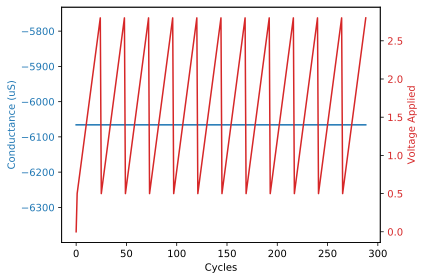

Working on array 0 , device (row= 1 col= 0 )
Array 0 , device (row= 1 col= 0 ) Init G= -0.006065786901270771  Target G= 14.0  Final G= -0.006065786901270771


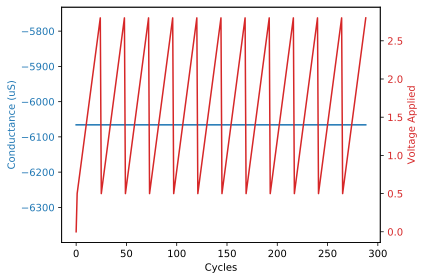

In [207]:
VreadGate = 5.0
vRead = 0.2
arr = 0
startRow = 0
startCol = 0
numRows = 2
numCols = 1
GMin = 2e-6
GMax = 20-6

targetGThresh = 4e-6
targetRows = np.arange(startRow, startRow+numRows)
targetCols = np.arange(startCol, startCol+numCols)

targetGVals = np.linspace(GMin, GMax, numRows)

vAppliedSet = np.arange(0.5, 2.9, 0.1)
vAppliedReset = np.arange(0.5, 3.2, 0.1)
vGateSet = np.arange(0.5, 1.7, 0.1)
vGateReset = np.arange(5.0, 5.5, 0.5)

GHistory = []
VHistory = []

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.3, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])

_gain_ratio = [
    1e3,
    5e3,
    30e3,
    200e3,
    1e6
]

vOffset = -0.08
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vgate = 5
Vref = 0.5

for j in range(numCols):
    cc = targetCols[j]
    for i in range(numRows):
        rr = targetRows[i]
        print('Working on array', arr, ', device (row=', rr, 'col=', cc, ')')
        thisGtarget = targetGVals[i]
        thisGHistory = []
        thisVHistory = []
        thisGainHistory = []
        # Do a first read of this device
        adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
        VADC_read_first = dut.adc2volt(adc_raw)
        gainFirst = adc_raw >> 10
        secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
        secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
        dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
        VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
        finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
        dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
        rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
        
        currG = rdCurr/vRead
        thisGHistory.append(currG)
        thisVHistory.append(0)
        #print('Initial G=', currG, 'Target G =', thisGtarget)
        initG = currG
        # Now, if device is lower than target, SET it
        if currG < (thisGtarget-targetGThresh):
            for vgate in vGateSet:
                for vappset in vAppliedSet:
                    # Apply vappset pulse, then read
                    a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                    VADC_read_first = dut.adc2volt(adc_raw)
                    gainFirst = adc_raw >> 10
                    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
                
                    currG = rdCurr/vRead
                    thisGHistory.append(currG)
                    thisVHistory.append(vappset)
                    if currG >= (thisGtarget-targetGThresh):
                        break
                if currG >= (thisGtarget-targetGThresh):
                    break
            GHistory.append(thisGHistory)
            VHistory.append(thisVHistory)

        # Else, if device is higher than target, RESET it, then SET it
        elif currG > (thisGtarget+targetGThresh):
            for vgate in vGateReset:
                for vappreset in vAppliedReset:
                    # Apply vappreset pulse, then read
                    a0.reset_single_int(vappreset, vgate, array=arr, row=rr, col=cc)

                    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                    VADC_read_first = dut.adc2volt(adc_raw)
                    gainFirst = adc_raw >> 10
                    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]

                    currG = rdCurr/vRead
                    thisGHistory.append(currG)
                    thisVHistory.append(-1*vappreset)
                    if currG <= (thisGtarget+targetGThresh):
                        break
                if currG <= (thisGtarget+targetGThresh):
                    break

            #Now if it is below Gtarget, then do SET operations; If it is above Gtarget, then Reset failed and device stuck ON
            
            #if currG <= thisGtarget and thisGtarget >= 2.5e-6:
            if currG <= (thisGtarget-targetGThresh):
                for vgate in vGateSet:
                    for vappset in vAppliedSet:
                        # Apply vappset pulse, then read
                        a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                        adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                        VADC_read_first = dut.adc2volt(adc_raw)
                        gainFirst = adc_raw >> 10
                        secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                        secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                        dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                        VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                        finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                        dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                        rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
                    
                        currG = rdCurr/vRead
                        thisGHistory.append(currG)
                        thisVHistory.append(vappset)
                        if currG >= (thisGtarget-targetGThresh):
                            break
                    if currG >= (thisGtarget-targetGThresh):
                        break

        GHistory.append(thisGHistory)
        VHistory.append(thisVHistory)
        print('Array', arr, ', device (row=', rr, 'col=', cc, ') Init G=', initG, ' Target G=', thisGtarget, ' Final G=', currG)

        fig, ax1 = plt.subplots()
        color = 'tab:blue'
        ax1.set_xlabel('Cycles')
        ax1.set_ylabel('Conductance (uS)', color=color)
        ax1.plot([i* 1e6 for i in thisGHistory], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  
        color = 'tab:red'
        ax2.set_ylabel('Voltage Applied', color=color)
        ax2.plot(thisVHistory, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()  
        plt.show()        